In [1]:
import fnmatch
import os
import pandas as pd
from os.path import isfile, join
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

In [2]:
data_directory = "/media/Carol/Dynamic/Experiments/Colloidal_Ice/Cairo_lattice/Analyzed_videos_h=2-w=2"

In [3]:
Cairo = []
for file in os.listdir(data_directory):
    if fnmatch.fnmatch(file, "vertices_h=2_w=2*.dat"):
        print(file)
        Cairo.append(pd.read_csv(join(data_directory,file), sep = "\t", index_col = [0,1])) 
        
keys_Cairo = []
for i in range(len(Cairo)):
    keys_Cairo.append(i)

vertices_h=2_w=24.dat
vertices_h=2_w=2.dat
vertices_h=2_w=26.dat
vertices_h=2_w=2_5.dat
vertices_h=2_w=21.dat
vertices_h=2_w=2_7.dat
vertices_h=2_w=25.dat
vertices_h=2_w=20.dat
vertices_h=2_w=2_2.dat
vertices_h=2_w=22.dat
vertices_h=2_w=23.dat
vertices_h=2_w=2_0.dat
vertices_h=2_w=2_8.dat


In [4]:
Cairo_exp = pd.concat(Cairo, keys = keys_Cairo)
Cairo_exp.index.names = ['Exp', 'frame', 'id']

In [5]:
Cairo_exp = Cairo_exp.query('coordination != 2')


In [6]:
Cairo_exp["type"] = np.NaN

# 4-fold vertices classification

Cairo_exp.loc[Cairo_exp.charge==-4, "type"] = "Q = -4"
Cairo_exp.loc[Cairo_exp.charge==-2, "type"] = "Q = -2"
Cairo_exp.loc[Cairo_exp.charge==+2, "type"] = "Q = +2"
Cairo_exp.loc[Cairo_exp.charge==+4, "type"] = "Q = +4"

zeroq = Cairo_exp.charge==0

dipole_magnitude = np.sqrt(Cairo_exp[zeroq].dx**2+Cairo_exp[zeroq].dy**2)

Cairo_exp.loc[zeroq & (dipole_magnitude<1), "type"] = "Q = 0"
Cairo_exp.loc[zeroq & (dipole_magnitude>2) , "type"] = "Q = 0"

# 3-fold vertices classification

Cairo_exp.loc[Cairo_exp.charge==+1, "type"] = "Q = +1"
Cairo_exp.loc[Cairo_exp.charge==-1, "type"] = "Q = -1"
Cairo_exp.loc[Cairo_exp.charge==+3, "type"] = "Q = +3"
Cairo_exp.loc[Cairo_exp.charge==-3, "type"] = "Q = -3"

In [7]:
Cairo_exp

x           y  coordination  charge        dx  \
Exp frame id                                                           
0   0     0   233.395105  138.990965             3       1  1.732051   
          1   272.784758  116.211214             4       0  2.732051   
          2   154.596736  217.789334             3      -1  1.732051   
          3    75.798368  138.990965             3      -1  1.732051   
          4   193.993503  116.196691             4      -2  1.732051   
...                  ...         ...           ...     ...       ...   
12  7000  29   35.401601   37.398323             4      -2 -1.000000   
          30  215.781175  234.403264             3      -1  1.000000   
          31  114.188021   37.401840             4       0 -0.732051   
          32  193.004941  273.800031             4       0  0.000000   
          33  271.802543  273.816744             4       0  0.000000   

                    dy    type  
Exp frame id                    
0   0     0  -1.000000  Q = +1  
          1   0.732051   Q = 0  
          2   1.000000  Q = -1  
          3   1.000000  Q = -1  
          4   1.000000  Q = -2  
...                ...     ...  
12  7000  29 -1.732051  Q = -2  
          30 -1.732051  Q = -1  
          31 -2.732051   Q = 0  
          32  0.000000   Q = 0  
          33  0.000000   Q = 0  

[43872 rows x 7 columns]

In [8]:
def count_vertices(vrt, exp = 'Exp', column = "type", column1 = "coordination", time = "frame"):
    vrt_count = vrt.groupby([exp,time,column,column1]).count().iloc[:,0].to_frame("number")

    vrt_count = vrt_count.reindex(pd.MultiIndex.from_product(
        [vrt_count.index.get_level_values(exp).unique(),
        vrt_count.index.get_level_values(time).unique(),
        vrt_count.index.get_level_values(column).unique(),
        vrt_count.index.get_level_values(column1).unique()]), fill_value = 0)

    total_vrt = vrt_count.groupby([exp,time,column1]).sum()
    array_coord = total_vrt.loc[vrt_count.index.get_level_values('frame')].number.values
    array_coordT = np.tile(array_coord[:2],int(len(vrt_count)/len(array_coord[:2])))# 2 coordination lattice 
    vrt_count["fraction"] = vrt_count.number / array_coordT
        
    return vrt_count

In [9]:
count_m = count_vertices(Cairo_exp)

In [10]:
v_counts_m = count_m.groupby(["frame","type","coordination"]).mean()
v_counts_m["err"] = count_m['fraction'].groupby(["frame","type","coordination"]).std()/np.sqrt(count_m['fraction'].groupby(["frame","type","coordination"]).count().values)

In [11]:
v_counts_m

number  fraction       err
frame type   coordination                              
0     Q = +1 3             8.846154  0.491453  0.033785
             4             0.000000  0.000000  0.000000
      Q = +2 3             0.000000  0.000000  0.000000
             4             3.692308  0.230769  0.033482
      Q = +3 3             1.153846  0.064103  0.016459
...                             ...       ...       ...
12200 Q = -3 4             0.000000  0.000000  0.000000
      Q = -4 3             0.000000  0.000000  0.000000
             4             0.000000  0.000000  0.000000
      Q = 0  3             0.000000  0.000000  0.000000
             4             0.461538  0.028846  0.028846

[2214 rows x 3 columns]

In [12]:
v_counts_m = v_counts_m.query('number != 0')
v_counts_m.head(10)

number  fraction       err
frame type   coordination                              
0     Q = +1 3             8.846154  0.491453  0.033785
      Q = +2 4             3.692308  0.230769  0.033482
      Q = +3 3             1.153846  0.064103  0.016459
      Q = +4 4             0.230769  0.014423  0.007602
      Q = -1 3             6.538462  0.363248  0.026401
      Q = -2 4             4.230769  0.264423  0.026624
      Q = -3 3             1.615385  0.089744  0.022274
      Q = -4 4             0.615385  0.038462  0.019430
      Q = 0  4             7.230769  0.451923  0.041357
100   Q = +1 3             8.615385  0.478632  0.035882

In [13]:
mpl.rc('text', usetex=False)
mpl.rcParams['figure.dpi'] = 75

mpl.rcParams['font.family'] = 'Arial'

mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["blue", "green", "purple", 
                                                    "orange", "royalblue", "limegreen", 
                                                    "blueviolet","darkorange", "tomato",
                                                    "red","black"])

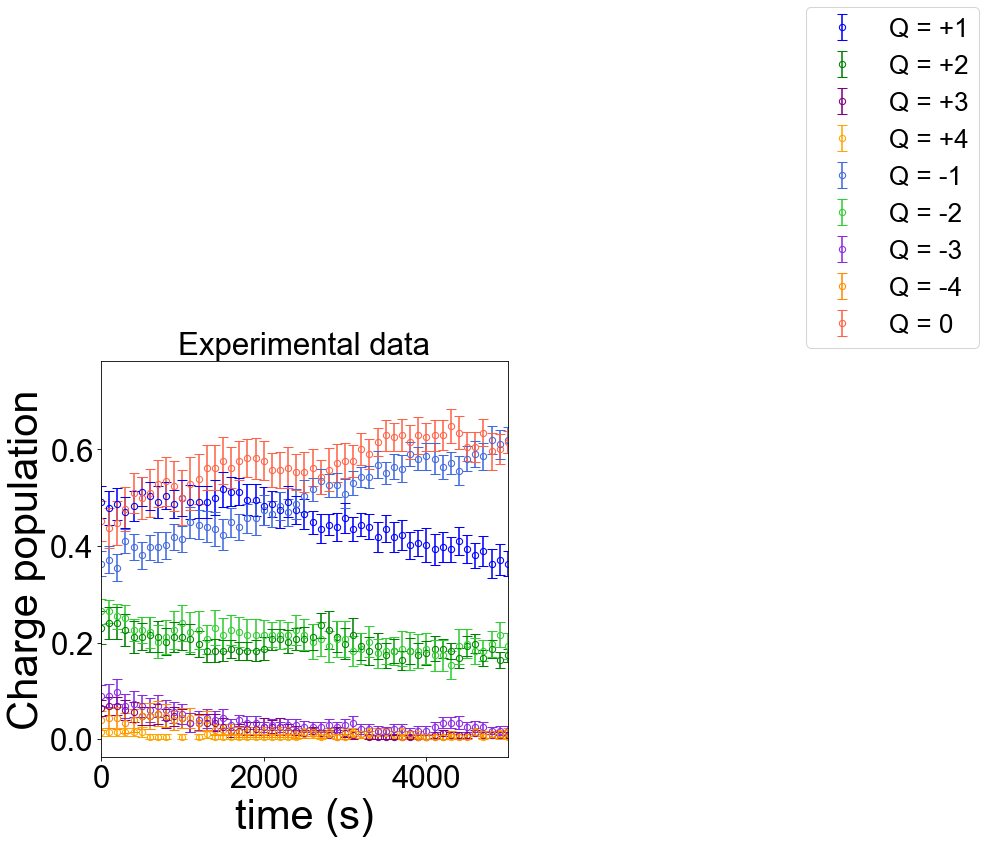

In [23]:
fig, ax1 = plt.subplots(figsize=(7,7))

#ax2 = ax1.twinx()



for typ_m, mtype in v_counts_m.groupby('type'):
    
    ax1.errorbar(mtype.index.get_level_values('frame'), mtype["fraction"],yerr = mtype["err"],dash_capstyle= 'butt',capsize=5, capthick=1, ls = '',fmt ='-o', fillstyle = 'none',label = typ_m)
    #ax1.errorbar(mtype.index.get_level_values('frame'), mtype["fraction"],yerr = mtype["err"], ls='--', marker='o', capsize=5, capthick=1, ecolor='black',label = typ_m)

    #ax1.plot(mtype.index.get_level_values('frame'), mtype["fraction"],'o', label = typ_m)

ax1.tick_params(axis='y', labelsize=30)
ax1.tick_params(axis='x', labelsize=30)  

ax1.legend(fontsize = 25, bbox_to_anchor=(1.7, 1))
ax1.set_xlabel('time (s)', size = 40)
ax1.set_ylabel('Charge population', size = 40)
ax1.set_title(f"Experimental data", size = 30)
ax1.set_xlim(0,5000)

#ax2.plot([0,2000,2500],[0,25,25],':', color = 'black', alpha = 0.5, lw = 5)


#ax2.set_ylabel('B (mT)', size = 40)
#ax2.tick_params(axis='y', labelsize=30)

#v_counts_m.to_csv('FreeBound.dat', sep = "\t")

plt.show()

NameError: name 'coord4' is not defined

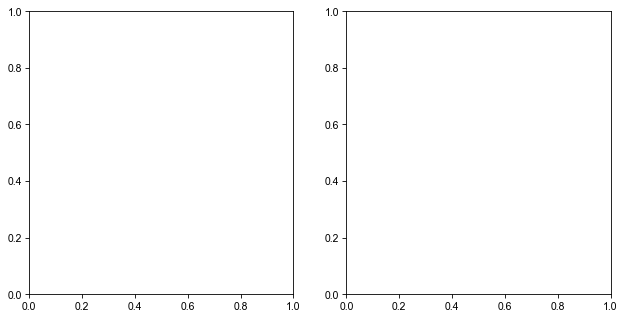

In [15]:
fig, ax = plt.subplots(1, 2,figsize=(10,5))

for typ_m, mtype in coord4.groupby('type'):
    print(typ_m)
    
    ax[0].errorbar(mtype.index.get_level_values("frame"), mtype["fraction"], fmt = '-o', label = typ_m)

for typ_m, mtype in coord3.groupby('type'):
    print(typ_m)
    ax[1].plot(mtype.index.get_level_values("frame"), mtype["fraction"],'-o',label = typ_m)

ax[0].tick_params(axis='y', labelsize=30)
ax[0].tick_params(axis='x', labelsize=30)  

ax[0].legend(fontsize = 12)
ax[0].set_xlabel('B (mT)', size = 40)
ax[0].set_ylabel('Charge population', size = 40)

ax[1].tick_params(axis='y', labelsize=30)
ax[1].tick_params(axis='x', labelsize=30)  

ax[1].legend(fontsize = 12)
ax[1].set_xlabel('B (mT)', size = 40)


plt.tight_layout()